# metaBEAT analysis of Illumina MiSeq output for Filtration_12S_July_2016

Mark sure your metaBEAT image version is the latest

`metaBEAT - metaBarcoding and Environmental DNA Analyses tool version: v.0.97.8-global`
Update from your terminal

####check the image, the latest ID should be 1f9e1e7d4566

sudo docker images
####if not, use the command to update the image from your terminal

sudo docker pull chrishah/metabeat


###The first step will be to trim/clean our raw Illumina data

In [1]:
!pwd

/home/working


In [2]:
!mkdir trimming

In [3]:
cd trimming

/home/working/trimming


__Prepare Querymap__


Prepare a text file specifying the samples to be processed including the format and location of the reads. 

The below command expects the Illumina data to be present in 2 fastq files (forward and reverse reads) per sample in a directory `./raw_reads/`. It expects the files to be named 'sampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively. 

The raw data need to be downloaded with `How_to_download_Rawdata_from_SRA.ipynb` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/raw_reads/How_to_download_Rawdata_from_SRA.ipynb))

SampleID must corresponds to the first column in the file `Sample_accessions.tsv` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/supplementary_data/Sample_accessions.tsv)), marker is '12S'.




In [4]:
!ls -l ../raw_reads/ 

total 277852
-rw-r--r-- 1 root root 1169883 Oct 31 14:35 T1-1-1-12S_R1.fastq.gz
-rw-r--r-- 1 root root 1080602 Oct 31 14:35 T1-1-1-12S_R2.fastq.gz
-rw-r--r-- 1 root root 5059798 Oct 31 14:35 T1-1-2-12S_R1.fastq.gz
-rw-r--r-- 1 root root 4350541 Oct 31 14:35 T1-1-2-12S_R2.fastq.gz
-rw-r--r-- 1 root root 1646705 Oct 31 14:35 T1-1-3-12S_R1.fastq.gz
-rw-r--r-- 1 root root 1524692 Oct 31 14:35 T1-1-3-12S_R2.fastq.gz
-rw-r--r-- 1 root root  997465 Oct 31 14:35 T1-1-4-12S_R1.fastq.gz
-rw-r--r-- 1 root root  915492 Oct 31 14:35 T1-1-4-12S_R2.fastq.gz
-rw-r--r-- 1 root root 1264645 Oct 31 14:35 T1-1-5-12S_R1.fastq.gz
-rw-r--r-- 1 root root 1119177 Oct 31 14:35 T1-1-5-12S_R2.fastq.gz
-rw-r--r-- 1 root root  923927 Oct 31 14:35 T1-2-1-12S_R1.fastq.gz
-rw-r--r-- 1 root root  896834 Oct 31 14:35 T1-2-1-12S_R2.fastq.gz
-rw-r--r-- 1 root root  874185 Oct 31 14:35 T1-2-2-12S_R1.fastq.gz
-rw-r--r-- 1 root root  809912 Oct 31 14:35 T1-2-2-12S_R2.fastq.gz
-rw-r--r-- 1 root root  696940 Oct 31 14:35 T1-2-

In [5]:

%%bash

for a in $(cat ../supplementary_data/Sample_accessions.tsv | grep "12S" | cut -f 1 | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a-12S_* | grep "_R1.fastq")
    R2=$(ls -1 ../raw_reads/$a-12S_* | grep "_R2.fastq")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

The resulting file should look e.g. like below:

In [6]:
!cat Querymap.txt

T1-1-1	fastq	../raw_reads/T1-1-1-12S_R1.fastq.gz	../raw_reads/T1-1-1-12S_R2.fastq.gz
T1-1-2	fastq	../raw_reads/T1-1-2-12S_R1.fastq.gz	../raw_reads/T1-1-2-12S_R2.fastq.gz
T1-1-3	fastq	../raw_reads/T1-1-3-12S_R1.fastq.gz	../raw_reads/T1-1-3-12S_R2.fastq.gz
T1-1-4	fastq	../raw_reads/T1-1-4-12S_R1.fastq.gz	../raw_reads/T1-1-4-12S_R2.fastq.gz
T1-1-5	fastq	../raw_reads/T1-1-5-12S_R1.fastq.gz	../raw_reads/T1-1-5-12S_R2.fastq.gz
T1-2-1	fastq	../raw_reads/T1-2-1-12S_R1.fastq.gz	../raw_reads/T1-2-1-12S_R2.fastq.gz
T1-2-2	fastq	../raw_reads/T1-2-2-12S_R1.fastq.gz	../raw_reads/T1-2-2-12S_R2.fastq.gz
T1-2-3	fastq	../raw_reads/T1-2-3-12S_R1.fastq.gz	../raw_reads/T1-2-3-12S_R2.fastq.gz
T1-2-4	fastq	../raw_reads/T1-2-4-12S_R1.fastq.gz	../raw_reads/T1-2-4-12S_R2.fastq.gz
T1-2-5	fastq	../raw_reads/T1-2-5-12S_R1.fastq.gz	../raw_reads/T1-2-5-12S_R2.fastq.gz
T1-3-1	fastq	../raw_reads/T1-3-1-12S_R1.fastq.gz	../raw_reads/T1-3-1-12S_R2.fastq.gz
T1-3-2	fastq	../raw_reads/T1-3-2-12S_R1.fastq.gz	../raw_reads/T1-


The 12S amplicon sequenced here is only 106bp long. Readlength used in the MiSeq run was 2x250bp. Our reads are thus longer than our amplicon and we so expect to find primer/adapter sequences in our reads that need to be removed as part of the raw data processing. 

Specifically, forward reads are expected to contain the reverse complement of the reverse primer plus the reverse Illumina adapter (FA501-FA508; FB501-FB508), and reverse reads will contain reverse complements of the forward primers and adapters (RA701-RA712;RB701-RB712).

The expected sequences have been produced from `12S-adapters.fasta` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/12S-adapters.fasta)) into reverse complements `12S-adapters_rc.fasta` and will be used in the trimming algorithm.

In [7]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
for record in SeqIO.parse("../12S-adapters.fasta", "fasta"):
    print record.id + "_rc"
    print record.seq.reverse_complement()

def make_rc_record(record):
    """Returns a new SeqRecord with the reverse complement sequence."""
    return SeqRecord(seq = record.seq.reverse_complement(), \
                 id = record.id + "_rc", \
                 description = "reverse complement")

records = map(make_rc_record, SeqIO.parse("../12S-adapters.fasta", "fasta"))
SeqIO.write(records, "../12S-adapters_rc.fasta", "fasta")


FA501_rc
GGGGTATCTAATCCCAGTCCAATTACCATACGTACGATGTGTAGATCTCGGTGGTCGCCGTATCATT
FA502_rc
GGGGTATCTAATCCCAGTCCAATTACCATACAGATAGTGTGTAGATCTCGGTGGTCGCCGTATCATT
FA503_rc
GGGGTATCTAATCCCAGTCCAATTACCATAACTCGCTAGTGTAGATCTCGGTGGTCGCCGTATCATT
FA504_rc
GGGGTATCTAATCCCAGTCCAATTACCATAACACGCAGGTGTAGATCTCGGTGGTCGCCGTATCATT
FA505_rc
GGGGTATCTAATCCCAGTCCAATTACCATACTCGATGAGTGTAGATCTCGGTGGTCGCCGTATCATT
FA506_rc
GGGGTATCTAATCCCAGTCCAATTACCATACACTCACGGTGTAGATCTCGGTGGTCGCCGTATCATT
FA507_rc
GGGGTATCTAATCCCAGTCCAATTACCATAAGATATCCGTGTAGATCTCGGTGGTCGCCGTATCATT
FA508_rc
GGGGTATCTAATCCCAGTCCAATTACCATAACGGTGTCGTGTAGATCTCGGTGGTCGCCGTATCATT
FB501_rc
GGGGTATCTAATCCCAGTCCAATTACCATATATAGTAGGTGTAGATCTCGGTGGTCGCCGTATCATT
FB502_rc
GGGGTATCTAATCCCAGTCCAATTACCATATAGTAACGGTGTAGATCTCGGTGGTCGCCGTATCATT
FB503_rc
GGGGTATCTAATCCCAGTCCAATTACCATAGTGACTCTGTGTAGATCTCGGTGGTCGCCGTATCATT
FB504_rc
GGGGTATCTAATCCCAGTCCAATTACCATAGTCTCGTAGTGTAGATCTCGGTGGTCGCCGTATCATT
FB505_rc
GGGGTATCTAATCCCAGTCCAATTACCATACGAGACGTGTGTAGATCTCGGTGGTCGCCGTATCATT

40

In [8]:
!cat ../12S-adapters_rc.fasta

>FA501_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACGTACGATGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA502_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACAGATAGTGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA503_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATAACTCGCTAGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA504_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATAACACGCAGGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA505_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACTCGATGAGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA506_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACACTCACGGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA507_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATAAGATATCCGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA508_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATAACGGTGTCGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FB501_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATATATAGTAGGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FB502_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATATAGTAACGGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FB503_rc reverse co

###Raw data trimming, removal of adapter sequences and merging of reads using the `metaBEAT` pipeline

In [9]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adjust_off]
                   [--min_bit <INT>] [--refpkg <DIR>] [--jplace <FILE>]


In [10]:
%%bash

metaBEAT_global.py \
-Q Querymap.txt \
--trim_qual 30 \
--trim_adapter ../12S-adapters_rc.fasta \
--trim_minlength 90 \
--merge \
--product_length 110 \
--forward_only \
--read_crop 106 \
-@ haikuilee@gmail.com \
-n 5 -v &> log

__Query survival after trimming__

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `metaBEAT_read_stats.csv`.

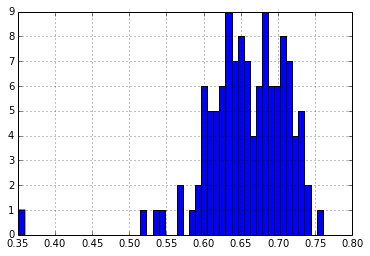

In [11]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

In [12]:
cd ../

/home/working


###Next stage of the processing is chimera detection and removal of putative chimeric sequences

We'll do that using `uchime` as implemented in `vsearch`.

In [13]:
!mkdir chimera_detection

In [14]:
cd chimera_detection

/home/working/chimera_detection


Convert reference database from Genbank to fasta format to be used in chimera detection.

Prepare Refmap file, i.e. text file that specifies the location and the format of the reference to be used.

The reference sequences in Genbank format should already be present in the `supplementary_data` directory: `12S_Fish_SATIVA_cleaned_May_2017.gb`.

In [15]:
%%bash

#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "12S_Fish_SATIVA_cleaned_May_2017.gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt



In [16]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb


In [19]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.8-global


Thu Nov  2 13:08:40 2017

/usr/bin/metaBEAT_global.py -R REFmap.txt -f


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

As the mail address is not specified in the script itself (variable 'Entrez.email'), metaBEAT expects a simple text file called 'user_email.txt' that contains your email address (first line of file) in the same location as the metaBEAT.py script (in your case: /usr/bin/)

found 'haikuilee@gmail.com' in /usr/bin/user_email.txt

taxonomy.db found at /usr/bin/taxonomy.db

######## PROCESSING REFERENCE DATA ########


processing ../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb (containing 340 records)

total number of valid records: 340

write out reference sequences to refs.fas

Traceback (most recent call last):
  File "/usr/bin/metaBEAT_global.py", line 2448, in <module>
    out.write(BIOM_tables_per_method['OTU_denovo'].to_tsv()) #to_json('generaged by test', direct_io=out)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 4027, in to_tsv
    observation_column_name)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 1268, in delimited_self
    raise TableException("Cannot delimit self if I don't have data...")
biom.exception.TableException: Cannot delimit self if I don't have data...


In [20]:
!head refs.fasta

>KC292935|7962|Cyprinus carpio
CCAGAAAAGAGAGATTTTAACTCTCACCCCTGGCTCCCAAAGCCAGAATTCTAAACTAAACTATTTTCTGGGGAGGTAGCACTCCCTTTATGGTATAGTACATATTATGCATAATATTACATTAATGTATTAGTACATATATGTATTATCACCAACTCACTATTTTAACCATAAAGCAGGTACATAATATTAAGGTGGGCATAAAGCATATTATTAAGACTCACAAATTCTATTATTTGGACTTGAGTAATATATTAATCCCCAAAAATTTGTCCTCAAATTTTTCCTTGAAATAATCAACTATAATTCCATTTAAACATATTAATGTAGTAAGAGACCACCAACCAGTTTATATAAAGGTATATCATGAATGATAGAATCAAGGACAATAATTGTGAGGGTTACACAATATGAACTATTACTGGCATCTGGTTCCTATTTCAGGGACATAACTGTAATATTCCACCCTCGGATAATTATACTGGCATCTGATTAATGGTGTAAGTACATACGTTTCATTACCCCCCATGCCGAGCATTCTTTTATATGCATAAGGTATTTTTTATTGGTTTCCTTTCATCTGGCATTTCAGAGTGCAGGCTCAAATGTTAAATCAAGGTTGAACATTTTCCTTGTATGTGATAATATATATTAATTATCGTAAGACATAATTTAAGAATTACATACTTTTATCTCAAGTGCATAATATATCTGTCTCTAGTTCAACTTATCCTTACATAGTGCCCCCTTTGGTTTTTGCGCGACAAACCCCCTTACCCCCTACGCTCAGCGAATCCTGTTATCCTTGTCAAACCCCGAAACCAAGGAGGACCCAAGAACGTGTAAACCAACGAGTTGAGGTATAAATTGGCATCCCATTATATATATATATATATATGCATCGGTTTTTTTAACCGCAACTTACCACTTACCTAAAAGCCCCTACCAAAAATCCCCAAAAAGAGGCTC

This will produce `refs.fasta`.

Now run chimera detection.

In [21]:
%%bash


for a in $(cut -f 1 ../trimming/Querymap.txt)
do
    if [ -s ../trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log
        cd ..

    else
        echo -e "$a is empty"
    fi
done





### Detecting chimeras in T1-1-1 ###


### Detecting chimeras in T1-1-2 ###


### Detecting chimeras in T1-1-3 ###


### Detecting chimeras in T1-1-4 ###


### Detecting chimeras in T1-1-5 ###


### Detecting chimeras in T1-2-1 ###


### Detecting chimeras in T1-2-2 ###


### Detecting chimeras in T1-2-3 ###


### Detecting chimeras in T1-2-4 ###


### Detecting chimeras in T1-2-5 ###


### Detecting chimeras in T1-3-1 ###


### Detecting chimeras in T1-3-2 ###


### Detecting chimeras in T1-3-3 ###


### Detecting chimeras in T1-3-4 ###


### Detecting chimeras in T1-3-5 ###


### Detecting chimeras in T1-4-1 ###


### Detecting chimeras in T1-4-2 ###


### Detecting chimeras in T1-4-3 ###


### Detecting chimeras in T1-4-4 ###


### Detecting chimeras in T1-4-5 ###


### Detecting chimeras in T2-1-1 ###


### Detecting chimeras in T2-1-2 ###


### Detecting chimeras in T2-1-3 ###


### Detecting chimeras in T2-1-4 ###


### Detecting chimeras in T2-1-5 ###


### Detecting chimeras i

###Last step is taxonomic assignment of reads based on a BLAST - LCA approach using the metaBEAT pipeline

In [6]:
cd ..

/home/working


In [7]:
!mkdir non-chimeras

In [8]:
cd non-chimeras/

/home/working/non-chimeras


__Prepare Querymap and Refmap txt files__

In [12]:
%%bash

#Querymap
for a in $(ls -l ../chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
   if [ "$a" != "GLOBAL" ]
   then
      echo -e "$a-nc\tfasta\t../chimera_detection/$a/$a-nonchimeras.fasta"
   fi
done > Querymap.txt


#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "12S_Fish_SATIVA_cleaned_May_2017.gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt

for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "Astatotilapia_calliptera.gb$")
do
      echo -e "$file\tgb"      
      
done >> REFmap.txt

In [13]:
!cat Querymap.txt

T1-1-1-nc	fasta	../chimera_detection/T1-1-1/T1-1-1-nonchimeras.fasta
T1-1-2-nc	fasta	../chimera_detection/T1-1-2/T1-1-2-nonchimeras.fasta
T1-1-3-nc	fasta	../chimera_detection/T1-1-3/T1-1-3-nonchimeras.fasta
T1-1-4-nc	fasta	../chimera_detection/T1-1-4/T1-1-4-nonchimeras.fasta
T1-1-5-nc	fasta	../chimera_detection/T1-1-5/T1-1-5-nonchimeras.fasta
T1-2-1-nc	fasta	../chimera_detection/T1-2-1/T1-2-1-nonchimeras.fasta
T1-2-2-nc	fasta	../chimera_detection/T1-2-2/T1-2-2-nonchimeras.fasta
T1-2-3-nc	fasta	../chimera_detection/T1-2-3/T1-2-3-nonchimeras.fasta
T1-2-4-nc	fasta	../chimera_detection/T1-2-4/T1-2-4-nonchimeras.fasta
T1-2-5-nc	fasta	../chimera_detection/T1-2-5/T1-2-5-nonchimeras.fasta
T1-3-1-nc	fasta	../chimera_detection/T1-3-1/T1-3-1-nonchimeras.fasta
T1-3-2-nc	fasta	../chimera_detection/T1-3-2/T1-3-2-nonchimeras.fasta
T1-3-3-nc	fasta	../chimera_detection/T1-3-3/T1-3-3-nonchimeras.fasta
T1-3-4-nc	fasta	../chimera_detection/T1-3-4/T1-3-4-nonchimeras.fasta
T1-3-5-nc	fasta	../chimera_detecti

In [14]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
../supplementary_data/reference_DBs/Astatotilapia_calliptera.gb	gb


__Sequence clustering and taxonomic assignment via metaBEAT__

In [16]:
%%bash

metaBEAT_global.py \
-Q Querymap.txt \
-R REFmap.txt \
--cluster --clust_match 1 --clust_cov 3 \
--blast --min_ident 1 \
-m 12S -n 5 \
-E -v \
-@ haikuilee@gmail.com \
-o 12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0 &> log

Final result of taxonomic assignment can be found in the table `12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.tsv` (see also [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/assignment_results/12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.tsv)). 

metaBEAT also produced the final result in [BIOM](http://biom-format.org/) format (`12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.biom`  see also [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/assignment_results/12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.biom)), which can be analyzed with a number of tools and visually explored e.g. using [Phinch](http://phinch.org/).